In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

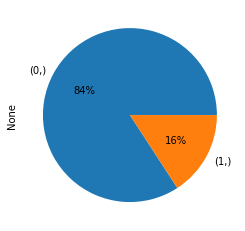

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

## Entrenando LGBM con hiperparámetros

In [4]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [5]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865319	training's binary_logloss: 0.285035	valid_1's auc: 0.85101	valid_1's binary_logloss: 0.296508
[200]	training's auc: 0.879707	training's binary_logloss: 0.273318	valid_1's auc: 0.854022	valid_1's binary_logloss: 0.294056
Early stopping, best iteration is:
[284]	training's auc: 0.88885	training's binary_logloss: 0.265847	valid_1's auc: 0.854905	valid_1's binary_logloss: 0.293443
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.864997	training's binary_logloss: 0.28516	valid_1's auc: 0.850819	valid_1's binary_logloss: 0.296441
[200]	training's auc: 0.879319	training's binary_logloss: 0.273464	valid_1's auc: 0.85398	valid_1's binary_logloss: 0.293806
Early stopping, best iteration is:
[281]	training's auc: 0.888196	training's binary_logloss: 0.266213	valid_1's auc: 0.854742	valid_1's binary_logloss: 0.29319
*********

In [7]:
fi.sort_values(ascending=False).head(50)

PRODUCTO_1_saldoMean_ult1meses                       0.008535
PRODUCTO_1_saldoMax_ult1meses                        0.008169
edad                                                 0.008121
ubigeo_mode                                          0.007866
PRODUCTO_1_saldoSum_ult1meses                        0.005791
PRODUCTO_1_saldoMedian_ult1meses                     0.005591
sexo_0                                               0.004987
PRODUCTO_3_saldoUnique_ult12meses                    0.004789
estadocontribuyente_0                                0.004754
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.004300
PRODUCTO_0_saldoMin_ult12meses                       0.004208
cod_instit_financiera_10_saldoStd_ult1meses          0.004180
PRODUCTO_6_saldoSum_ult12meses                       0.004148
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.004094
PRODUCTO_4_saldoStd_ult12meses                       0.004014
PRODUCTO_3_saldoMean_ult1meses                       0.003921
PRODUCTO

In [8]:
fi.to_pickle('fi_lightgbm.pkl')

In [9]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Catboost con parametros casi estandar
### CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)

In [10]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Learning rate set to 0.128212
0:	test: 0.7424907	test1: 0.7439484	best: 0.7439484 (0)	total: 871ms	remaining: 14m 29s
100:	test: 0.8471984	test1: 0.8422880	best: 0.8422880 (100)	total: 54.7s	remaining: 8m 6s
200:	test: 0.8576204	test1: 0.8475353	best: 0.8475353 (200)	total: 1m 47s	remaining: 7m 5s
300:	test: 0.8651702	test1: 0.8496751	best: 0.8496775 (299)	total: 2m 39s	remaining: 6m 11s
400:	test: 0.8713331	test1: 0.8509214	best: 0.8509214 (400)	total: 3m 30s	remaining: 5m 14s
500:	test: 0.8763042	test1: 0.8515765	best: 0.8515909 (498)	total: 4m 19s	remaining: 4m 18s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.851979197
bestIteration = 561

Shrink model to first 562 iterations.
********** 1 **********
Learning rate set to 0.128212
0:	test: 0.7257203	test1: 0.7278298	best: 0.7278298 (0)	total: 633ms	remaining: 10m 31s
100:	test: 0.8471016	test1: 0.8432364	best: 0.8432364 (100)	total: 58s	remaining: 8m 36s
200:	test: 0.8573899	test1: 0.848

In [12]:
fi.to_pickle('fi_catboost.pkl')

In [13]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## Entrenamiento de modelo XgBoost

In [14]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [15]:
from xgboost  import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = XGBClassifier(n_estimators=1000, booster='gbtree', colsample_bytree=0.8, 
                            subsample = 0.8, max_depth=4,  learning_rate=0.3)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.71867	validation_1-auc:0.72320
[100]	validation_0-auc:0.86630	validation_1-auc:0.84686
[159]	validation_0-auc:0.87726	validation_1-auc:0.84776
********** 1 **********
[0]	validation_0-auc:0.72019	validation_1-auc:0.71819
[100]	validation_0-auc:0.86656	validation_1-auc:0.84752
[112]	validation_0-auc:0.86884	validation_1-auc:0.84768
********** 2 **********
[0]	validation_0-auc:0.71867	validation_1-auc:0.72510
[100]	validation_0-auc:0.86763	validation_1-auc:0.85002
[175]	validation_0-auc:0.88030	validation_1-auc:0.85072
********** 3 **********
[0]	validation_0-auc:0.72175	validation_1-auc:0.72340
[100]	validation_0-auc:0.86695	validation_1-auc:0.84898
[130]	validation_0-auc:0.87246	validation_1-auc:0.84919
********** 4 **********
[0]	validation_0-auc:0.72201	validation_1-auc:0.70930
[100]	validation_0-auc:0.86989	validation_1-auc:0.84073
[143]	validation_0-auc:0.87738	validation_1-auc:0.84112
*********************
roc auc estimado:  0.8475722843014554
roc auc varian

In [16]:
fi.sort_values(ascending=False).head(50)

PRODUCTO_12_saldoMin_ult1meses                      0.075974
RIESGO_DIRECTO_2_saldoMean_ult1meses                0.052980
RIESGO_DIRECTO_2_saldoMin_ult2meses                 0.045184
COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult1meses    0.042137
COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses       0.022472
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult2meses       0.020933
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult4meses       0.020831
PRODUCTO_12_saldoMax_ult1meses                      0.017672
COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult4meses    0.016055
COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult4meses    0.015935
tipo_credito_11_saldoMean_ult1meses                 0.015827
COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult2meses    0.015041
condicion_1_saldoMax_ult2meses                      0.013716
RIESGO_DIRECTO_2_saldoMedian_ult1meses              0.012992
RIESGO_DIRECTO_2_saldoMean_ult2meses                0.012878
PRODUCTO_0_saldoMedian_ult1meses                    0.011044
cod_instit_financiera_ma

In [17]:
fi.to_pickle('fi_xgb.pkl')

In [18]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_xgb.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_xgb.pkl')

## Entrenando Neural Network Artificial

In [15]:
train = pd.read_pickle('../data/train_1072features_score_0.85381.pkl') 
test = pd.read_pickle('../data/test_1072features_score_0.85381.pkl')
train.shape, test.shape

((358487, 1072), (396666, 1072))

In [16]:
#### eliminar variable cuyo porcentaje de valores nulos es mayor al 90%
aux = train.isna().sum()/len(train)
drop_columns = list(aux[aux>=0.9].index)
train.drop(drop_columns, axis=1, inplace=True)
test.drop(drop_columns, axis=1, inplace=True)
train.shape, test.shape

((358487, 722), (396666, 722))

In [17]:
fi = pd.read_pickle('fi_lightgbm.pkl')
fi.loc[train.columns].sum()

0.7950576708840491

In [18]:
var_missing_values = list(train.isna().sum()[train.isna().sum()>0].index)
len(var_missing_values)

659

In [19]:
var_mode =[i for i in var_missing_values if "mode" in i]
var_std =[i for i in var_missing_values if "Std" in i or "std" in i]
var_unique =[i for i in var_missing_values if "Unique" in i or "unique" in i ]
var_mean =[i for i in var_missing_values if "Mean" in i or "mean" in i]
var_median =[i for i in var_missing_values if "Median" in i or "median" in i]
var_sum =[i for i in var_missing_values if "Sum" in i or "sum" in i]
var_max =[i for i in var_missing_values if "Max" in i or "max" in i]
var_min =[i for i in var_missing_values if "Min" in i or "min" in i]
len(var_mode), len(var_std), len(var_unique), len(var_mean), len(var_median), len(var_sum),len(var_max), len(var_min)

(11, 101, 95, 85, 103, 98, 79, 73)

In [20]:
var_total = var_mode+var_std+var_unique+var_mean+var_median+var_sum+var_max+var_min
var_rest = list(set(var_missing_values).difference(var_total))
len(set(var_total)), len(set(var_rest))

(645, 14)

#### imputacion tradicional

In [21]:
for i in var_mode:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0])
for i in var_std:
    train[i] = train[i].fillna(0)   
    test[i] = test[i].fillna(0)   
for i in var_unique:
    train[i] = train[i].fillna(0)   
    test[i] = test[i].fillna(0)   
for i in var_mean:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_median:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_sum:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_max:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_min:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_rest:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   

In [22]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.models import load_model
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import Callback

In [23]:
def get_one_hot(y_train):
    one_hot =[]
    for i in y_train.values:
        aux=[]
        for j in [0,1]:
            if i==j:
                aux.append(1)
            else:
                aux.append(0)
        one_hot.append(aux)
    return  np.array(one_hot)

In [24]:
def get_model_keras(one_hot):
    model_rnn = Sequential()
    model_rnn.add(Dense(128,input_dim=len(train.columns),activation="relu"))
    model_rnn.add(Dropout(0.5))
    model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid")) # sigmoid
    optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#     sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
    model_rnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['AUC'])
    return model_rnn

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [26]:
train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

In [27]:
# https://keras.rstudio.com/reference/fit.html
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]
    yt = get_one_hot(yt)

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]
    yv = get_one_hot(yv)
    
    learner = get_model_keras(yv)
    
    num_epochs = 100
    num_batch_size = 1024
#     num_steps_per_epoch = len(Xt)//batch_size      steps_per_epoch = num_steps_per_epoch
    num_validation_steps = 10
    learner.fit(Xt, yt ,epochs=num_epochs, batch_size=num_batch_size, 
                        validation_steps=num_validation_steps)    
    
    test_probs.append(pd.Series(learner.predict(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict(Xv)[:, -1], index=Xv.index, name="probs"))
    print(f'roc_auc estimado en fold {i} : {roc_auc_score(yv[:,-1],learner.predict(Xv)[:,-1])}')
#     fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
# fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))

********** 0 **********
Epoch 1/100
281/281 [==============================] - 5s 13ms/step - loss: 0.3936 - auc: 0.9037
Epoch 2/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3390 - auc: 0.9281
Epoch 3/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3310 - auc: 0.9314
Epoch 4/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3271 - auc: 0.9327
Epoch 5/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3226 - auc: 0.9343
Epoch 6/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3202 - auc: 0.9355
Epoch 7/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3210 - auc: 0.9348
Epoch 8/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3172 - auc: 0.9363
Epoch 9/100
281/281 [==============================] - 4s 14ms/step - loss: 0.3172 - auc: 0.9362
Epoch 10/100
281/281 [==============================] - 4s 15ms/step - loss: 0.3172 - auc: 0.9366
Epoch

281/281 [==============================] - 3s 11ms/step - loss: 0.3038 - auc: 0.9427
Epoch 66/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3069 - auc: 0.9413
Epoch 67/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3056 - auc: 0.9423
Epoch 68/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3034 - auc: 0.9427
Epoch 69/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3024 - auc: 0.9428
Epoch 70/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3031 - auc: 0.9430
Epoch 71/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3047 - auc: 0.9422
Epoch 72/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3017 - auc: 0.9429
Epoch 73/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3038 - auc: 0.9426
Epoch 74/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3042 - auc: 0.9422
Epoch 75/100
281/281 [===========

281/281 [==============================] - 4s 14ms/step - loss: 0.3057 - auc: 0.9413
Epoch 49/100
281/281 [==============================] - 4s 14ms/step - loss: 0.3045 - auc: 0.9418
Epoch 50/100
281/281 [==============================] - 4s 14ms/step - loss: 0.3117 - auc: 0.9413
Epoch 51/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3023 - auc: 0.9426
Epoch 52/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3071 - auc: 0.9412
Epoch 53/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3072 - auc: 0.9413
Epoch 54/100
281/281 [==============================] - 4s 14ms/step - loss: 0.3049 - auc: 0.9417
Epoch 55/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3082 - auc: 0.9412
Epoch 56/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3042 - auc: 0.9420
Epoch 57/100
281/281 [==============================] - 4s 14ms/step - loss: 0.3041 - auc: 0.9421
Epoch 58/100
281/281 [===========

281/281 [==============================] - 3s 11ms/step - loss: 0.3080 - auc: 0.9406
Epoch 32/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3078 - auc: 0.9405
Epoch 33/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3083 - auc: 0.9404
Epoch 34/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3076 - auc: 0.9405
Epoch 35/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3083 - auc: 0.9406
Epoch 36/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3073 - auc: 0.9407
Epoch 37/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3096 - auc: 0.9402
Epoch 38/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3096 - auc: 0.9404
Epoch 39/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3058 - auc: 0.9415
Epoch 40/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3058 - auc: 0.9412
Epoch 41/100
281/281 [===========

281/281 [==============================] - 3s 12ms/step - loss: 0.3022 - auc: 0.9437
Epoch 97/100
281/281 [==============================] - 4s 12ms/step - loss: 0.2995 - auc: 0.9442
Epoch 98/100
281/281 [==============================] - 3s 12ms/step - loss: 0.2979 - auc: 0.9448
Epoch 99/100
281/281 [==============================] - 4s 12ms/step - loss: 0.2996 - auc: 0.9443
Epoch 100/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3009 - auc: 0.9436
roc_auc estimado en fold 4 : 0.8303349442370902
*********************
roc auc estimado:  0.8345968107570514
roc auc varianza:  0.0011019752674203027


In [ ]:
########     num_batch_size = 512   
###  num_epochs = 7   0.818
###  num_epochs = 15  0.82300
###  num_epochs = 30  0.82598
###  num_epochs = 50  0.82720 , num_batch_size = 1028 
###  num_epochs = 50   0.829800 , num_batch_size = 1028 

In [28]:
train_probs_rnn = train_probs
test_probs_rnn = test_probs
train_probs_rnn.to_pickle('train_probs_rnn.pkl')
test_probs_rnn.to_pickle('test_probs_rnn.pkl')

## Entrenando GradientBosstingClassifier

In [33]:
train = pd.read_pickle('../data/train_1072features_score_0.85381.pkl') 
test = pd.read_pickle('../data/test_1072features_score_0.85381.pkl')
train.shape, test.shape

((358487, 1072), (396666, 1072))

In [34]:
#### eliminar variable cuyo porcentaje de valores nulos es mayor al 90%
aux = train.isna().sum()/len(train)
drop_columns = list(aux[aux>=0.9].index)
train.drop(drop_columns, axis=1, inplace=True)
test.drop(drop_columns, axis=1, inplace=True)
train.shape, test.shape

((358487, 722), (396666, 722))

In [35]:
var_missing_values = list(train.isna().sum()[train.isna().sum()>0].index)
len(var_missing_values)

659

In [36]:
var_mode =[i for i in var_missing_values if "mode" in i]
var_std =[i for i in var_missing_values if "Std" in i or "std" in i]
var_unique =[i for i in var_missing_values if "Unique" in i or "unique" in i ]
var_mean =[i for i in var_missing_values if "Mean" in i or "mean" in i]
var_median =[i for i in var_missing_values if "Median" in i or "median" in i]
var_sum =[i for i in var_missing_values if "Sum" in i or "sum" in i]
var_max =[i for i in var_missing_values if "Max" in i or "max" in i]
var_min =[i for i in var_missing_values if "Min" in i or "min" in i]
len(var_mode), len(var_std), len(var_unique), len(var_mean), len(var_median), len(var_sum),len(var_max), len(var_min)

(11, 101, 95, 85, 103, 98, 79, 73)

In [37]:
var_total = var_mode+var_std+var_unique+var_mean+var_median+var_sum+var_max+var_min
var_rest = list(set(var_missing_values).difference(var_total))
len(set(var_total)), len(set(var_rest))

(645, 14)

#### imputacion tradicional

In [38]:
for i in var_mode:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0])
for i in var_std:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_unique:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_mean:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_median:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_sum:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_max:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_min:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_rest:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [40]:
train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.3, subsample=0.8,
                                         max_depth=5, verbose=1, max_features=0.82, random_state=407,
                                         n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)
   
    learner.fit(Xt, yt)        
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7815           0.0915          278.93m
         2           0.7452           0.0350          272.83m
         3           0.7239           0.0209          278.99m
         4           0.7068           0.0132          284.68m
         5           0.6972           0.0129          285.99m
         6           0.6839           0.0107          282.11m
         7           0.6758           0.0063          278.90m
         8           0.6695           0.0043          277.24m
         9           0.6643           0.0058          274.54m
        10           0.6571           0.0051          275.34m
        20           0.6294           0.0008          271.47m
********** 1 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7829           0.0869          243.62m
         2           0.7470           0.0367          241.60m
         3          

In [43]:
fi.sort_values(ascending=False).head(50)

PRODUCTO_6_saldoMax_ult1meses                        0.110742
PRODUCTO_6_saldoStd_ult1meses                        0.086564
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult1meses     0.048600
tipo_credito_11_saldoMean_ult1meses                  0.029850
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.028807
tipo_credito_12_saldoSum_ult1meses                   0.026034
PRODUCTO_6_saldoMean_ult1meses                       0.022871
PRODUCTO_2_saldoSum_ult1meses                        0.020884
RIESGO_DIRECTO_-1_saldoUnique_ult4meses              0.020172
RIESGO_DIRECTO_1_saldoMean_ult1meses                 0.017078
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult2meses     0.016885
cod_instit_financiera_32_saldoUnique_ult1meses       0.015936
COD_CLASIFICACION_DEUDOR_1_saldoSum_ult7meses        0.013079
tipo_credito_12_saldoMin_ult1meses                   0.011971
RIESGO_DIRECTO_1_saldoMax_ult12meses                 0.011764
PRODUCTO_3_saldoMean_ult1meses                       0.011302
tipo_cre

In [44]:
fi.to_pickle('fi_gbc.pkl')

In [45]:
train_probs_gbc = train_probs
test_probs_gbc = test_probs
train_probs_gbc.to_pickle('train_probs_gbc.pkl')
test_probs_gbc.to_pickle('test_probs_gbc.pkl')

In [46]:
train.dtypes.value_counts()

float64    722
dtype: int64

### Test ensamble CB and LGBM (Promedio Simple)

In [58]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') 
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

((358487, 1136), (396666, 1136))

In [64]:
fi = pd.read_pickle('fi_lightgbm.pkl')
fi.sort_values(ascending=False).head(600).sum()

0.8187536048650496

In [66]:
from lightgbm import LGBMClassifier
fi = pd.read_pickle('fi_lightgbm.pkl')
features_importances_250_lightgbm = list(fi.sort_values(ascending=False).head(600).index)
learner_lightgbm = LGBMClassifier(n_estimators=1000, max_depth=6, boosting_type='gbdt', min_child_samples=1000)
learner_lightgbm.fit(train[features_importances_250_lightgbm], y_train.target, eval_metric="auc", verbose=True)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=1000, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [67]:
from catboost import CatBoostClassifier
fi = pd.read_pickle('fi_catboost_v2.pkl')
features_importances_250_catboost = list(fi.sort_values(ascending=False).head(600).index)
learner_catboost = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth = 6)
learner_catboost.fit(train[features_importances_250_catboost], y_train,  early_stopping_rounds=10, verbose=False)

In [68]:
test_probs_catboost = pd.Series(learner_catboost.predict_proba(test[features_importances_250_catboost])[:, -1], index=test.index, name="target")
test_probs_lightgbm = pd.Series(learner_lightgbm.predict_proba(test[features_importances_250_lightgbm])[:, -1], index=test.index, name="target")
test_probs_mean = test_probs_catboost*0.4 + test_probs_lightgbm*0.6
test_probs_mean.name = 'target'
test_probs_mean.shape

(396666,)

In [69]:
test_probs_mean.to_csv("../results/test_simpleEnsamble_CB_LGBM.csv") ## ### score de 0.84900 en la tabla publica

In [75]:
test_stacking = pd.read_csv("../results/stacking_3models_LGBM2_GBC_0.84805.csv", index_col = 'key_value')
test_stacking = pd.Series(test_stacking['target'], index=test_stacking.index)
test_stacking

key_value
0         0.046411
1         0.082767
2         0.054280
3         0.569868
4         0.136302
            ...   
396661    0.070589
396662    0.175882
396663    0.200699
396664    0.058848
396665    0.069094
Name: target, Length: 396666, dtype: float64

In [76]:
test_probs_mean_ = test_probs_mean*0.5 + test_stacking*0.5
test_probs_mean_

key_value
0         0.024140
1         0.079244
2         0.039947
3         0.446672
4         0.169947
            ...   
396661    0.068474
396662    0.201868
396663    0.213891
396664    0.049055
396665    0.052579
Name: target, Length: 396666, dtype: float64

In [77]:
test_probs_mean_.to_csv("../results/emsamble_simple_and_stacking.csv") ## ### score de 0.85042 en la tabla publica

In [78]:
test_probs_mean_2 = test_probs_mean*0.4 + test_stacking*0.6
test_probs_mean_2

key_value
0         0.028594
1         0.079948
2         0.042814
3         0.471311
4         0.163218
            ...   
396661    0.068897
396662    0.196671
396663    0.211253
396664    0.051013
396665    0.055882
Name: target, Length: 396666, dtype: float64

In [79]:
test_probs_mean_2.to_csv("../results/emsamble_simple_and_stacking_v2.csv") ## ### score de 0.85042 en la tabla publica